In [1]:
import gzip
import lzma
import ffmpeg
import zlib

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

from functools import partial
from collections import Counter
import glob

from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Useful functions

In [2]:
class jpeg2000:
    def compress(im):    
        buffer = BytesIO()
        im.save(buffer, "JPEG2000")
        buffer.seek(0)
        return buffer.read()
    
class jpeg:
    def compress(im):       
        buffer = BytesIO()
        im.save(buffer, "JPEG")
        buffer.seek(0)
        return buffer.read()
    
class png:        
    def compress(im):
        buffer = BytesIO()
        im.save(buffer, "PNG")
        buffer.seek(0)
        return buffer.read()

In [3]:
def concat_imgs(img1, img2):
    """
    Concatene two images vertically
    """
    new_img = Image.new('L', (img1.width, img1.height + img2.height))
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (0, img1.height))
    return new_img

In [4]:
def ncd_dist(img1_path, img2_path, compressor=lzma, verbose=False):
    """
    Compute NCD distance with the given compressor
    """
    
    #open images
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    
    #concatene images
    concat_img = concat_imgs(img1,img2)
    
    if compressor in [lzma, gzip, zlib]:
        #for lzma and gzip we need to convert images in bytes.
        #for others, we directly compress the images with PIL
        img1 = img1.tobytes()
        img2 = img2.tobytes()
        concat_img = concat_img.tobytes()

    #compress the two images and concatened image
    img1_comp = compressor.compress(img1)
    img2_comp = compressor.compress(img2)
    concat_img_comp = compressor.compress(concat_img)
        
    if verbose:
        print('C(img1): %f'%len(img1_comp))
        print('C(img2): %f'%len(img2_comp))
        print('C(concat): %f'%len(concat_img_comp))

    return (len(concat_img_comp) - min(len(img1_comp), len(img2_comp)))/(max(len(img1_comp), len(img2_comp)))

In [5]:
img1 = 'yalefaces/yalefaces/subject02.glasses'
img2 = 'yalefaces/yalefaces/subject02.glasses'

ncd_dist(img1, img2, compressor=gzip, verbose=True)

C(img1): 38963.000000
C(img2): 38963.000000
C(concat): 77861.000000


0.9983317506352181

In [6]:
def VideoCompression(img1_path, img2_path, compressor='mpeg1video'):
    """
    Encode two images with MPEG-1 compressor and return the compressed size.
    """
    imgs = ffmpeg.concat(
        ffmpeg.input(img1_path, format='image2', vcodec='gif'),
        ffmpeg.input(img2_path, format='image2', vcodec='gif'),
    )

    stream = imgs.output('pipe:', format='rawvideo', vcodec=compressor)
    stream = stream.global_args( '-loglevel', 'error').run_async(pipe_stdout=True)
    compression = stream.stdout.read()
    return len(compression)

In [7]:
def video_dist(img1_path, img2_path, compressor='mpeg1video'):
    """
    Compute CK-1 distance with the corresponding compressor
    """
    Cx_y = VideoCompression(img1_path, img2_path, compressor)
    Cy_x = VideoCompression(img2_path, img1_path, compressor)
    Cx_x = VideoCompression(img1_path, img1_path, compressor)
    Cy_y = VideoCompression(img2_path, img2_path, compressor)

    return (Cx_y + Cy_x)/(Cx_x + Cy_y) -1

In [8]:
def custom_dist_sklearn(a,b, compressor='mpeg1'):
    """
    Adapted custom distance function to work with sklearn KNN. 
    Takes two indices and return the distance of the two
    images at those indices based on the given compressor.
    """
    global images
    
    comp_map = {'gzip': partial(ncd_dist,compressor=gzip), 'lzma': partial(ncd_dist,compressor=lzma),
                'mpeg1': partial(video_dist, compressor='mpeg1video'), 'jpeg': partial(ncd_dist,compressor=jpeg),
                'jpeg2': partial(ncd_dist,compressor=jpeg2000), 'png': partial(ncd_dist,compressor=png),
                'h264': partial(video_dist, compressor='h264')}
    img1_path = images[int(a)]
    img2_path = images[int(b)]
    return comp_map[compressor](img1_path, img2_path)

In [9]:
def predict_and_plot(clf, indices, labels, test):
    """
    Compute distance between test individual and all other individuals. 
    Return the most frequent individual among closest neighbors.    
    """
    global images
    
    # remove test individual from train set
    Xtrain = np.delete(indices, test)
    ytrain = np.delete(labels, test)
    
    # fit and predict
    clf.fit(Xtrain.reshape(-1, 1), ytrain)
    #pred = clf.predict(np.array([[test]]))
    
    
    #show nearest neighbors with distances
    d, l = clf.kneighbors([[test]], n_neighbors=10, return_distance=True)
    nn = Xtrain[l].ravel()
    d = d.ravel()
    
    fig, axs = plt.subplots(2,5, figsize=(15, 5))
    axs = axs.ravel()
    
    img = Image.open(images[test]).convert('RGB')
    axs[0].imshow(img)
    axs[0].title.set_text('Query image')
    axs[0].set_xticks([]) 
    axs[0].set_yticks([]) 
    for i,k in enumerate(Xtrain[l].ravel()[:-1]):
        img = Image.open(images[k]).convert('RGB')
        axs[i+1].imshow(img)
        axs[i+1].title.set_text('Match n°%d, d=%.4f'%(i+1, d[i]))
        axs[i+1].set_xticks([]) 
        axs[i+1].set_yticks([]) 
    
    #show prediction
    preds = np.array(labels)[nn[:clf_lzma.get_params()['n_neighbors']]]
    pred = Counter(preds.flat).most_common(1)[0][0]
    
    print('True individual: %s'%labels[test])
    print('Predicted individual: %s'%pred)

## Experiments

In [10]:
images = glob.glob('yalefaces/yalefaces/*')
labels = [x.split('/')[-1].split('.')[0] for x in images]
indices = np.arange(len(labels))


clf_ck1 = KNeighborsClassifier(n_neighbors=3, algorithm='brute', 
                               metric=custom_dist_sklearn, metric_params={'compressor':'mpeg1'})
clf_h264 = KNeighborsClassifier(n_neighbors=1, algorithm='brute', 
                               metric=custom_dist_sklearn, metric_params={'compressor':'h264'})
clf_gzip = KNeighborsClassifier(n_neighbors=3, algorithm='brute',
                                metric=custom_dist_sklearn, metric_params={'compressor':'gzip'})
clf_lzma = KNeighborsClassifier(n_neighbors=3, algorithm='brute',
                                metric=custom_dist_sklearn, metric_params={'compressor':'lzma'})
clf_jpeg = KNeighborsClassifier(n_neighbors=3, algorithm='brute',
                                metric=custom_dist_sklearn, metric_params={'compressor':'jpeg'})
clf_jpeg2 = KNeighborsClassifier(n_neighbors=3, algorithm='brute',
                                metric=custom_dist_sklearn, metric_params={'compressor':'jpeg2'})
clf_png = KNeighborsClassifier(n_neighbors=3, algorithm='brute',
                                metric=custom_dist_sklearn, metric_params={'compressor':'png'})
loo = LeaveOneOut()

scores_gzip = cross_val_score(clf_gzip, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
print('gzip mean score: %f'%np.mean(scores_gzip))

scores_lzma = cross_val_score(clf_lzma, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
print('lzma mean score: %f'%np.mean(scores_lzma))

scores_jpeg = cross_val_score(clf_jpeg, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
print('jpeg mean score: %f'%np.mean(scores_jpeg))

scores_jpeg2 = cross_val_score(clf_jpeg2, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
print('jpeg2000 mean score: %f'%np.mean(scores_jpeg2))

scores_png = cross_val_score(clf_png, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
print('png mean score: %f'%np.mean(scores_png))

scores_ck1 = cross_val_score(clf_ck1, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
print('ck1 mean score: %f'%np.mean(scores_ck1))

scores_h264 = cross_val_score(clf_h264, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
print('h264 mean score: %f'%np.mean(scores_h264))

gzip mean score: 0.078313
lzma mean score: 0.427711
jpeg mean score: 0.066265
jpeg2000 mean score: 0.271084
png mean score: 0.024096
ck1 mean score: 0.771084
h264 mean score: 0.855422


## jpeg2000 compressor

True individual: subject07
Predicted individual: subject10


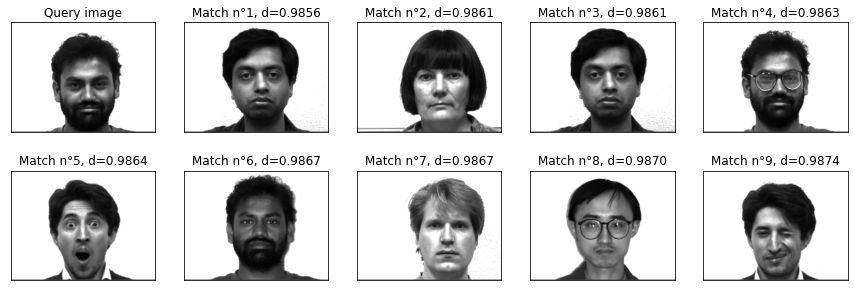

In [11]:
predict_and_plot(clf_jpeg2, indices, labels, 101)

## lzma compressor

True individual: subject07
Predicted individual: subject07


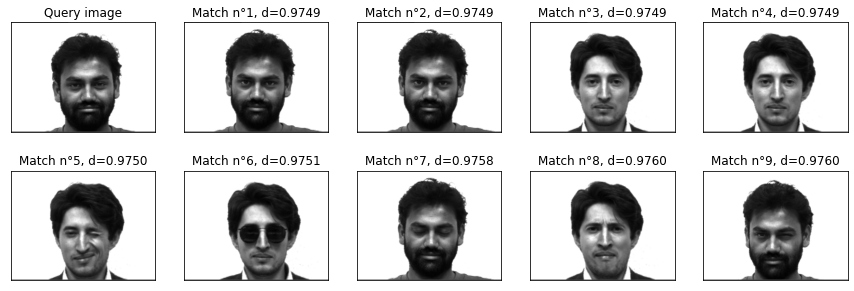

In [12]:
predict_and_plot(clf_lzma, indices, labels, 101)

True individual: subject13
Predicted individual: subject13


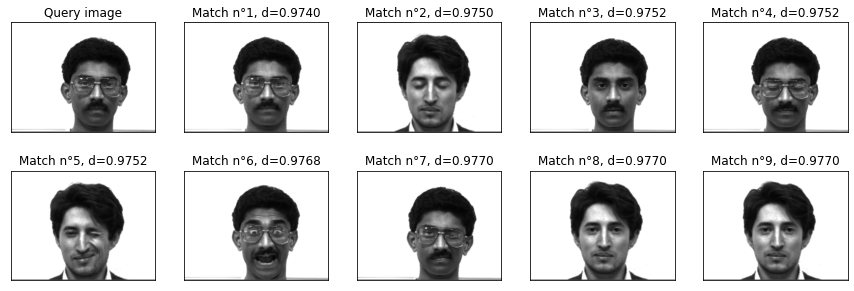

In [13]:
predict_and_plot(clf_lzma, indices, labels, 1)

True individual: subject08
Predicted individual: subject03


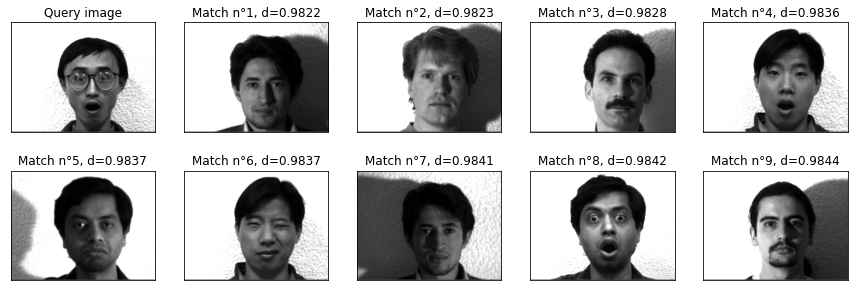

In [14]:
predict_and_plot(clf_lzma, indices, labels, 165)

## MPEG-1 compressor

True individual: subject07
Predicted individual: subject07


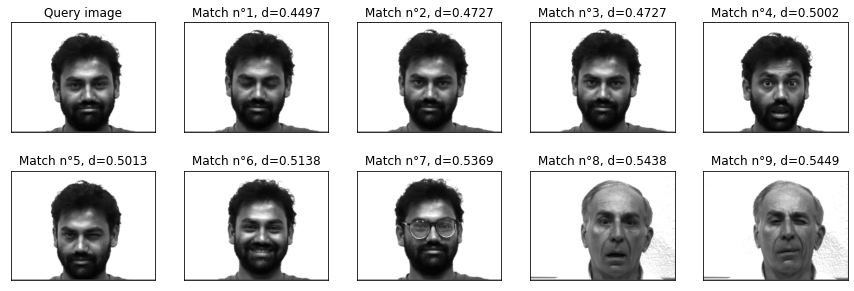

In [15]:
predict_and_plot(clf_ck1, indices, labels, 101)

True individual: subject13
Predicted individual: subject13


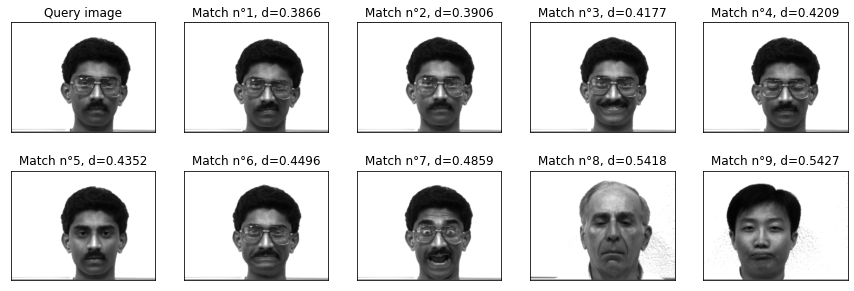

In [16]:
predict_and_plot(clf_ck1, indices, labels, 1)

True individual: subject08
Predicted individual: subject01


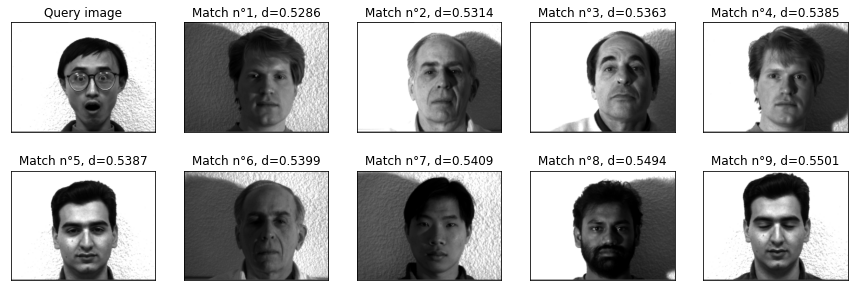

In [17]:
predict_and_plot(clf_ck1, indices, labels, 165)

## h264 compressor

True individual: subject07
Predicted individual: subject07


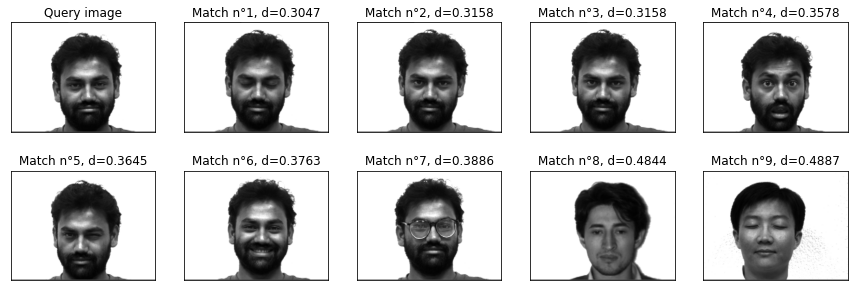

In [18]:
predict_and_plot(clf_h264, indices, labels, 101)

True individual: subject13
Predicted individual: subject13


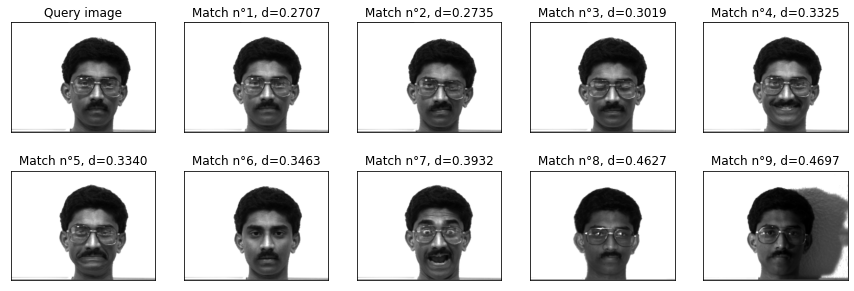

In [19]:
predict_and_plot(clf_h264, indices, labels, 1)

True individual: subject08
Predicted individual: subject08


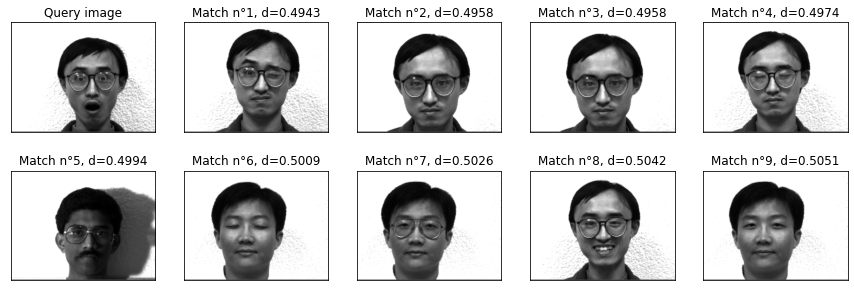

In [20]:
predict_and_plot(clf_h264, indices, labels, 165)